In [1]:
import pandas as pd
import numpy as np
import json
import os
import re
import tempfile
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
files = 'contrib.pkl debt.pkl expense.pkl filer.pkl receipt.pkl'.split(' ')
fps = [os.path.join('data', x) for x in files]

In [3]:
contrib = pd.read_pickle(fps[0])
debt = pd.read_pickle(fps[1])
expense = pd.read_pickle(fps[2])
filer = pd.read_pickle(fps[3])
receipt = pd.read_pickle(fps[4])

In [4]:
import geopandas as gpd
import shapely

# Load PA house

In [31]:
fname = os.path.join('data', 'PA_house.geojson')

with open(fname, 'r') as f:
    a = f.readlines()
pa_counties = gpd.read_file(fname, driver='GeoJSON')

# Exporting to geojson

In [5]:
from geojson import Feature, FeatureCollection, Point
import geojson

In [6]:
def to_geojson(df):
    for i, x in df.iterrows():
        geometry = None
        if not np.isnan(x.lat):
            geometry = Point((x.long, x.lat))
        properties = json.loads(x.to_json())
        yield Feature(geometry=geometry,
                      properties=properties)
    return

In [7]:
fc = FeatureCollection([y for y in to_geojson(debt)])

In [8]:
import tempfile
from os.path import join
import shutil

def load_feature_collection(fc):
    # Convert a FeatureCollection to a GeoDataFrame.
    # Note: Workaround Fiona bullshit
    #
    # Args:
    #   fc - a geojson FeatureCollection
    # Returns:
    #   a GeoPandas GeoDataFrame
    tempdir = tempfile.mkdtemp()
    fname = join(tempdir, 'temp.json')

    with open(fname, 'w') as f:
        geojson.dump(fc, f, allow_nan=True)

    gdf = gpd.read_file(fname, driver='GeoJSON')
    shutil.rmtree(tempdir)
    return gdf

In [9]:
gdf = load_feature_collection(fc)

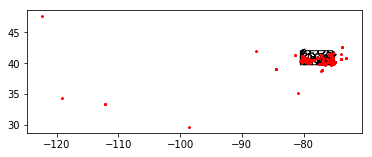

In [69]:
base = pa_counties.plot(color='white', edgecolor='black')
gdf.plot(ax=base, marker='*', color='red', markersize=5);

## simplified $l^\infty$ distance finding

* Each degree of latitude is approximately 69 miles (111 kilometers) apart.
    * 1 mile $\approx 1/69$ degree
* Each degree of longitude is about $\frac{a \pi}{180} \cos (lat)$, where $a = 3,959$ miles.
    * 1 mile $\approx \frac{180 \sec(lat)}{3959 \pi}$


In [65]:
import math

def lat_to_mile():
    return 1.0 / 69.0


def long_to_mile(lat):
    return 180 / (3959 * math.pi * math.cos(lat * math.pi / 180))


def filter_distance(df, lat, long, dist):
    delta_lat = dist * lat_to_mile()
    delta_long = dist * long_to_mile(lat)
    return df[df.lat.between(lat - delta_lat, lat + delta_lat)
              & df.long.between(long - delta_long, long + delta_long)]

In [64]:
lat = 39.9352144
long = -75.1720487

filter_distance(expense, lat, long, 1).shape

(516, 19)